# Political success, May 2021

In [1]:
import pandas
import numpy
from numpy import std, correlate, sqrt
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm
from linearmodels import IV2SLS
%run Table_Summary.ipynb

In [50]:
data = pandas.read_csv(r'D:/BP/Data/APA_ASA.txt',sep='\t')
data['MAR'] = pandas.to_numeric(data.MAR, errors='coerce')
data['MRR'] = 100 - 100*data['MAR']
data['Subscriptions'] = data['Printed_Subsc_Institutional']
data['Journal'] = data.groupby(['ID'])[['Journal']].fillna(method='ffill')
data['ASA'] = data.groupby(['ID'])[['ASA']].fillna(method='ffill')
data = data[~((data.Journal=='Contexts') | (data.Journal=='Rose'))]
data = data[['Journal','Year','MRR','JIF','Subscriptions','Citable_Items','JIF_Percentile','ASA']]
data = data.set_index(['Journal','Year']).sort_index()
data

MRR    JIF  Subscriptions  Citable_Items  \
Journal               Year                                              
American Psychologist 2004  85.2  5.494         1938.0           36.0   
                      2005  76.4  6.460         1599.0           46.0   
                      2006  74.8  7.829         1532.0           46.0   
                      2007  84.5  6.967         1330.0           48.0   
                      2008  77.8  7.106         1219.0           34.0   
...                          ...    ...            ...            ...   
Teaching Sociology    2012  80.9    NaN         2176.0            NaN   
                      2013  84.0  0.980         2892.0           33.0   
                      2014  85.3  0.464         2995.0           26.0   
                      2015   NaN  0.559         3049.0           24.0   
                      2016   NaN  0.480            NaN           19.0   

                            JIF_Percentile  ASA  
Journal               Year                       
American Psychologist 2004          95.500  0.0  
                      2005          96.535  0.0  
                      2006          95.455  0.0  
                      2007          96.569  0.0  
                      2008          96.535  0.0  
...                                    ...  ...  
Teaching Sociology    2012             NaN  1.0  
                      2013          57.609  1.0  
                      2014          26.408  1.0  
                      2015          29.930  1.0  
                      2016          21.329  1.0  

[516 rows x 6 columns]

## Sample

In [51]:
print(data.shape[0],'Year-academic journal observations')
print(data.reset_index().Journal.nunique(),'Journals')
print(data.reset_index().groupby('ASA')['Journal'].nunique())

516 Year-academic journal observations
38 Journals
ASA
0.0    30
1.0     8
Name: Journal, dtype: int64


## Figure 1

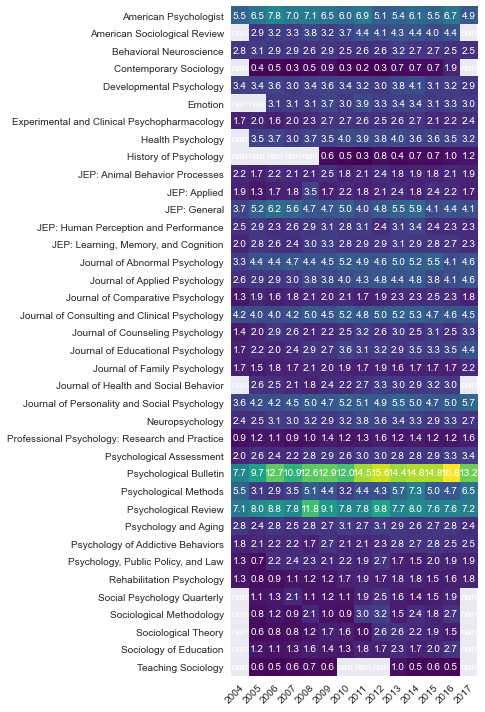

In [52]:
Journals = data.index.unique(level='Journal').tolist()
Years = data.index.unique(level='Year').tolist()
JIFS = data['JIF'].round(1).unstack().values
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(JIFS,cmap='viridis')
ax.set_xticks(numpy.arange(len(Years)))
ax.set_yticks(numpy.arange(len(Journals)))
ax.set_xticklabels(Years)
ax.set_yticklabels(Journals)
ax.grid(False)
plt.setp(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode="anchor")
for i in range(len(Journals)):
    for j in range(len(Years)):
        text = ax.text(j,i,JIFS[i,j],ha="center",va="center",color="w")
fig.tight_layout()
plt.show()
fig.savefig('Figure1.svg')

## Variables

In [53]:
mydf = data.copy()
mydf = mydf.reset_index()
mydf['SA']=mydf.groupby(['Year']).JIF.transform('mean')
mydf['SA']=mydf['SA'].rolling(window=5,min_periods=1).mean()
mydf['JIF']=mydf.groupby(['Journal'])['JIF'].rolling(window=5,min_periods=1).mean().reset_index(0,drop=True)
mydf['distance']=mydf['JIF']-mydf['SA']
mydf.loc[mydf.distance<0,'Political Success']=mydf['SA']
mydf.loc[mydf.distance>0,'Political Success']=1.05*mydf['JIF']
mydf['Subscriptions']=numpy.log(mydf['Subscriptions'])
mydf['JIF Percentile'] = mydf.groupby('Year')['JIF_Percentile'].transform(pandas.qcut,2,labels=False,duplicates='drop')
mydf['Citable Items'] = mydf.groupby('Year')['Citable_Items'].transform(pandas.qcut,2,labels=False,duplicates='drop')
mydf

,Journal,Year,MRR,JIF,Subscriptions,Citable_Items,JIF_Percentile,ASA,SA,distance,Political Success,JIF Percentile,Citable Items
0,American Psychologist,2004,85.2,5.494000,7.569412,36.0,95.500,0.0,2.907630,2.586370,5.768700,1.0,0.0
1,American Psychologist,2005,76.4,5.977000,7.377134,46.0,96.535,0.0,2.829190,3.147810,6.275850,1.0,0.0
2,American Psychologist,2006,74.8,6.594333,7.334329,46.0,95.455,0.0,2.890892,3.703441,6.924050,1.0,0.0
3,American Psychologist,2007,84.5,6.687500,7.192934,48.0,96.569,0.0,2.899298,3.788202,7.021875,1.0,0.0
4,American Psychologist,2008,77.8,6.771200,7.105786,34.0,96.535,0.0,2.984611,3.786589,7.109760,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,Teaching Sociology,2012,80.9,0.663500,7.685244,NaN,NaN,1.0,3.300109,-2.636609,3.300109,NaN,NaN
512,Teaching Sociology,2013,84.0,0.781000,7.969704,33.0,57.609,1.0,3.319557,-2.538557,3.319557,0.0,0.0
513,Teaching Sociology,2014,85.3,0.722000,8.004700,26.0,26.408,1.0,3.383563,-2.661563,3.383563,0.0,0.0
514,Teaching Sociology,2015,NaN,0.667667,8.022569,24.0,29.930,1.0,3.398727,-2.731061,3.398727,0.0,0.0


## Statistics

In [54]:
mydata = mydf[['MRR','Political Success','Subscriptions','Citable Items','JIF Percentile','ASA']]
print(len(mydata),'Number of observations')
ds_mean = mydata.agg(['count','mean','std']).T
corr = mydata.corr()
corr = pandas.concat([ds_mean,corr], axis = 1)
corr = corr.applymap('{:.4f}'.format)
corr['statistics'] = ' '
corr.set_index('statistics',append=True,inplace=True)
print(corr)
def pearsonr_pval(x,y):
  return pearsonr(x,y)[1].round(3)
pval = mydata.corr(method=pearsonr_pval)
pval = pval.applymap('{:.3f}'.format)
pval = pval.applymap(lambda x: '(' + x + ')')
pval['statistics'] = 'p-value'
pval.set_index('statistics',append=True,inplace=True)

statistics = pandas.concat([corr,pval],axis=0).sort_index(kind='merge').reindex(['MRR','Political Success','Subscriptions','Citable Items','JIF Percentile','ASA'],axis=0,level=0)
statistics.to_excel('Statistics-PS_main.xlsx',float_format="%.3f")
statistics

516 Number of observations
                                 count     mean      std      MRR  \
                  statistics                                        
MRR                           499.0000  76.1277  13.8385   1.0000   
Political Success             508.0000   4.0188   1.9183   0.1794   
Subscriptions                 460.0000   5.8047   1.2690   0.4112   
Citable Items                 500.0000   0.4920   0.5004  -0.0626   
JIF Percentile                493.0000   0.4929   0.5005   0.4665   
ASA                           516.0000   0.1860   0.3895   0.4030   

                             Political Success Subscriptions Citable Items  \
                  statistics                                                 
MRR                                     0.1794        0.4112       -0.0626   
Political Success                       1.0000        0.1928       -0.1796   
Subscriptions                           0.1928        1.0000       -0.0361   
Citable Items                 

count     mean      std      MRR  \
                  statistics                                        
MRR                           499.0000  76.1277  13.8385   1.0000   
                  p-value          NaN      NaN      NaN  (1.000)   
Political Success             508.0000   4.0188   1.9183   0.1794   
                  p-value          NaN      NaN      NaN  (0.000)   
Subscriptions                 460.0000   5.8047   1.2690   0.4112   
                  p-value          NaN      NaN      NaN  (0.000)   
Citable Items                 500.0000   0.4920   0.5004  -0.0626   
                  p-value          NaN      NaN      NaN  (0.170)   
JIF Percentile                493.0000   0.4929   0.5005   0.4665   
                  p-value          NaN      NaN      NaN  (0.000)   
ASA                           516.0000   0.1860   0.3895   0.4030   
                  p-value          NaN      NaN      NaN  (0.000)   

                             Political Success Subscriptions Citable Items  \
                  statistics                                                 
MRR                                     0.1794        0.4112       -0.0626   
                  p-value              (0.000)       (0.000)       (0.170)   
Political Success                       1.0000        0.1928       -0.1796   
                  p-value              (1.000)       (0.000)       (0.000)   
Subscriptions                           0.1928        1.0000       -0.0361   
                  p-value              (0.000)       (1.000)       (0.447)   
Citable Items                          -0.1796       -0.0361        1.0000   
                  p-value              (0.000)       (0.447)       (1.000)   
JIF Percentile                          0.4122        0.3724        0.0903   
                  p-value              (0.000)       (0.000)       (0.046)   
ASA                                    -0.1811        0.4854       -0.4548   
                  p-value              (0.000)       (0.000)       (0.000)   

                             JIF Percentile      ASA  
                  statistics                          
MRR                                  0.4665   0.4030  
                  p-value           (0.000)  (0.000)  
Political Success                    0.4122  -0.1811  
                  p-value           (0.000)  (0.000)  
Subscriptions                        0.3724   0.4854  
                  p-value           (0.000)  (0.000)  
Citable Items                        0.0903  -0.4548  
                  p-value           (0.046)  (0.000)  
JIF Percentile                       1.0000  -0.0211  
                  p-value           (1.000)  (0.641)  
ASA                                 -0.0211   1.0000  
                  p-value           (0.641)  (1.000)

## Preparing data for regression

In [55]:
XY = mydf.copy()
XY = XY[['MRR','Political Success','Subscriptions','JIF Percentile','Citable Items','Journal','Year']]
XY = XY.dropna()
X1 = XY[['Political Success','Subscriptions','JIF Percentile','Citable Items','Journal','Year']]
X1 = pandas.get_dummies(X1,columns=['Journal','Year'])
X1 = X1.drop(['Journal_American Psychologist','Year_2004'],axis=1)
X1['Political Success'] = X1['Political Success']-X1['Political Success'].mean()
X1['Subscriptions'] = X1['Subscriptions']-X1['Subscriptions'].mean()
X1['Political Success*Subscriptions'] = X1['Political Success'] * X1['Subscriptions']
X1['Intercept'] = 1
X0 = X1.drop(['Political Success*Subscriptions'],axis=1)

## Regression

In [60]:
r0 = []
r1 = []
window = 5
reg0 = sm.OLS(XY['MRR'],X0).fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':window**2})
r0.append((reg0.params,reg0.bse,reg0.pvalues,reg0.rsquared_adj))
print(reg0.summary())
reg1 = sm.OLS(XY['MRR'],X1).fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':window**2})
r1.append((reg1.params,reg1.bse,reg1.pvalues,reg1.rsquared_adj))
reg1.summary()

                            OLS Regression Results                            
Dep. Variable:                    MRR   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                -2.855e+14
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               1.00
Time:                        12:29:41   Log-Likelihood:                -1431.0
No. Observations:                 434   AIC:                             2970.
Df Residuals:                     380   BIC:                             3190.
Df Model:                          53                                         
Covariance Type:         hac-groupsum                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

c:\users\ainhoa.urtasun\.myvirtualenv\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 53, but rank is 13
  warnings.warn('covariance of constraints does not have full '
c:\users\ainhoa.urtasun\.myvirtualenv\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 54, but rank is 13
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MRR   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                 1.056e+13
Date:                Tue, 27 Apr 2021   Prob (F-statistic):          2.44e-216
Time:                        12:29:41   Log-Likelihood:                -1430.9
No. Observations:                 434   AIC:                             2972.
Df Residuals:                     379   BIC:                             3196.
Df Model:                          54                                         
Covariance Type:         hac-groupsum                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Political Success                                          0.8974      0.129      6.937      0.000       0.644       1.151
Subscriptions                                             -0.7042      0.279     -2.525      0.012      -1.251      -0.158
JIF Percentile                                             0.6585      0.514      1.281      0.200      -0.349       1.666
Citable Items                                             -1.8298      0.554     -3.305      0.001      -2.915      -0.745
Journal_American Sociological Review                      18.0245      0.869     20.753      0.000      16.322      19.727
Journal_Behavioral Neuroscience                          -16.9639      3.057     -5.549      0.000     -22.956     -10.972
Journal_Contemporary Sociology                            -8.0295      2.010     -3.995      0.000     -11.969      -4.090
Journal_Developmental Psychology                           1.2985      0.866      1.500      0.134      -0.398       2.995
Journal_Emotion                                           -1.3416      3.376     -0.397      0.691      -7.958       5.275
Journal_Experimental and Clinical Psychopharmacology     -32.0254      2.728    -11.739      0.000     -37.373     -26.678
Journal_Health Psychology                                  7.3460      1.003      7.322      0.000       5.380       9.312
Journal_History of Psychology                            -13.6943      1.414     -9.687      0.000     -16.465     -10.923
Journal_JEP: Animal Behavior Processes                   -19.2736      1.674    -11.516      0.000     -22.554     -15.993
Journal_JEP: Applied                                       4.4965      1.687      2.666      0.008       1.191       7.802
Journal_JEP: General                                       4.4316      2.105      2.106      0.035       0.307       8.557
Journal_JEP: Human Perception and Performance             -4.1336      1.273     -3.248      0.001      -6.628      -1.639
Journal_JEP: Learning, Memory, and Cognition               3.2648      0.928      3.520      0.000       1.447       5.083
Journal_Journal of Abnormal Psychology                     7.0475      0.695     10.133      0.000       5.684       8.411
Journal_Journal of Applied Psychology                     14.0932      1.150     12.257      0.000      11.840      16.347
Journal_Journal of Comparative Psychology                -26.1143      2.005    -13.023      0.000     -30.045     -22.184
Journal_Journal of Consulting and Clinical Psychology      2.8314      0.941      3.009      0.003       0.987       4.676
Journal_Journal of Counseling Psychology                   4.4822      1.295      3.461      0.001       1.944       7.020
Journal_

In [78]:
table0 = Table_Summary(r0)
table0 = table0.reindex(['Political Success','Subscriptions','Citable Items','JIF Percentile','Intercept','Adjusted R2'],level=0)
table0 = table0.reindex(['Coeff','CSE','p-val',''],level=1)
table0.columns = ['Base Model']

table1 = Table_Summary(r1)
table1 = table1.reindex(['Political Success','Subscriptions','Political Success*Subscriptions','Citable Items','JIF Percentile','Intercept','Adjusted R2'],level=0)
table1 = table1.reindex(['Coeff','CSE','p-val',''],level=1)
table1.columns = ['Full Model']

table = pandas.merge(table0,table1,on=['Variables','Statistics'],how='outer')
table = table.reindex(['Political Success','Subscriptions','Political Success*Subscriptions','Citable Items','JIF Percentile','Intercept','Adjusted R2'],level=0)
table.round(3)

Base Model  Full Model
Variables                       Statistics                        
Political Success               Coeff            0.996       0.897
                                CSE              0.142       0.129
                                p-val            0.000       0.000
Subscriptions                   Coeff           -0.636      -0.704
                                CSE              0.270       0.279
                                p-val            0.018       0.012
Political Success*Subscriptions Coeff              NaN      -0.134
                                CSE                NaN       0.066
                                p-val              NaN       0.042
Citable Items                   Coeff           -1.717      -1.830
                                CSE              0.553       0.554
                                p-val            0.002       0.001
JIF Percentile                  Coeff            0.651       0.659
                                CSE              0.511       0.514
                                p-val            0.203       0.200
Intercept                       Coeff           76.898      77.434
                                CSE              1.080       1.191
                                p-val            0.000       0.000
Adjusted R2                                      0.726       0.726

In [79]:
table.to_excel('Table-PS_main.xlsx',float_format="%.3f")

## Endogeneity test

In [73]:
XY = mydf.copy()
XY['Instrument'] = XY.groupby(['Journal'])['Political Success'].shift(5)
XY = XY[['MRR','Political Success','Instrument','Subscriptions','Citable Items','JIF Percentile','Journal','Year']]
XY = XY.dropna()
X = XY[['Political Success','Instrument','Subscriptions','Citable Items','JIF Percentile','Journal','Year']]
X = pandas.get_dummies(X,columns=['Journal','Year'])
X = X.drop(['Journal_American Psychologist','Year_2009'],axis=1)
X['Political Success'] = X['Political Success']-X['Political Success'].mean()
X['Subscriptions'] = X['Subscriptions']-X['Subscriptions'].mean()
X['Political Success*Subscriptions'] = X['Political Success'] * X['Subscriptions']
X['Intercept'] = 1
res_2sls = IV2SLS(XY['MRR'],X.drop(['Political Success','Instrument'],axis=1),X['Political Success'],X.Instrument).fit()
print(res_2sls.wu_hausman())
reg1s = sm.OLS(X['Political Success'],X[['Intercept','Instrument']],axis=1).fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':22})
X['residuals'] = reg1s.resid
reg2s = sm.OLS(XY['MRR'],X.drop(['Instrument'],axis=1)).fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':22})
null_hypothesis = '(residuals = 0)'
print(reg2s.f_test(null_hypothesis))
statistic = reg2s.params['residuals']**2/reg2s.cov_params().loc[['residuals'],['residuals']]
statistic

c:\users\ainhoa.urtasun\.myvirtualenv\lib\site-packages\linearmodels\iv\data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.3075
P-value: 0.5798
Distributed: F(1,234)
<F test: F=array([[2.71082876]]), p=0.10862070250412104, df_denom=35, df_num=1>


,residuals
residuals,2.710829


## Interaction plot

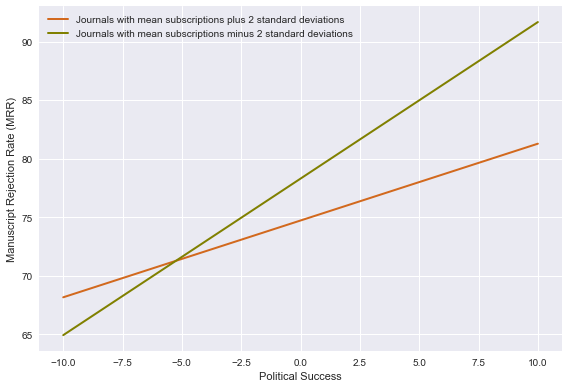

In [74]:
# 100 linearly spaced numbers
x = numpy.linspace(-10,10,100)
y1 = 0.996*x - 1.830*0.5 - 0.704*2.54 - 0.134*2.54*x + 77.434
y2 = 0.996*x - 1.830*0.5 + 0.704*2.54 + 0.134*2.54*x  + 77.434

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(x, y1, color='chocolate', linewidth=2, label='Journals with mean subscriptions plus 2 standard deviations')
axes.plot(x, y2, color='olive', linewidth=2, label='Journals with mean subscriptions minus 2 standard deviations')
axes.set_ylabel('Manuscript Rejection Rate (MRR)')
axes.set_xlabel('Political Success')
axes.legend()
fig.tight_layout()
plt.show()
fig.savefig('Figure2.svg')